<a href="https://colab.research.google.com/github/Riddhi123-svg/COPD-Recognition-Model/blob/main/COPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Configuration ---
SOURCE_ROOT = '/content/drive/MyDrive/real_copd /archive (1)/img_data' # <--- !! UPDATE THIS PATH !!
OUTPUT_ROOT = 'COPD_Xray_Project_Dataset/'

# 1. Map the downloaded folder names (source) to your desired project class names (target)
CLASS_MAPPING = {
    'Edema': 'COPD',      # Images from 'edema' folder will be labeled 'COPD'
    'NoEdema': 'Normal'   # Images from 'NOedema' folder will be labeled 'Normal'
}

SPLIT_RATIOS = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Collecting Data and Creating Labels from Folder Structure
data_list = []

for source_label, target_label in CLASS_MAPPING.items():
    class_dir = os.path.join(SOURCE_ROOT, source_label)

    if not os.path.isdir(class_dir):
        print(f"Error: Directory not found for class: {source_label}. Please check your SOURCE_ROOT path.")
        continue

    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            data_list.append({
                'filename': filename,
                'source_label': source_label,
                'label': target_label
            })

df_raw = pd.DataFrame(data_list)
print(f"Found a total of {len(df_raw)} images.")

# Spliting the Data to train test and val
df_train, df_temp = train_test_split(
    df_raw,
    train_size=SPLIT_RATIOS['train'],
    stratify=df_raw['label'],
    random_state=42
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=SPLIT_RATIOS['test'] / (SPLIT_RATIOS['val'] + SPLIT_RATIOS['test']),
    stratify=df_temp['label'],
    random_state=42
)

# Assigning the split names
df_train['split'] = 'train'
df_val['split'] = 'val'
df_test['split'] = 'test'

df_final = pd.concat([df_train, df_val, df_test])

print("\nSplit Distribution:")
print(df_final['split'].value_counts())
print("\nClass Distribution in Final Dataset:")
print(df_final['label'].value_counts())


# Creating Folders, Copying Files, and Generating Final CSV file---
os.makedirs(OUTPUT_ROOT, exist_ok=True)
final_csv_data = []

label_map = {target_label: i for i, target_label in enumerate(CLASS_MAPPING.values())}

for index, row in df_final.iterrows():
    split_name = row['split']
    target_label = row['label']
    source_label = row['source_label']
    filename = row['filename']

    # Defining paths
    source_path = os.path.join(SOURCE_ROOT, source_label, filename) # Read from 'edema' folder
    dest_folder = os.path.join(OUTPUT_ROOT, split_name, target_label) # Write to 'COPD' folder
    dest_path = os.path.join(dest_folder, filename)
    os.makedirs(dest_folder, exist_ok=True)
    try:
        shutil.copyfile(source_path, dest_path)
    except FileNotFoundError:
        print(f"Skipping missing file: {source_path}")
        continue

    final_csv_data.append({
        'file_path': os.path.join(split_name, target_label, filename),
        'split': split_name,
        'label': target_label,
        'label_numeric': label_map[target_label]
    })

# Generating the final labels.csv ---
labels_df = pd.DataFrame(final_csv_data)
labels_df.to_csv(os.path.join(OUTPUT_ROOT, 'labels.csv'), index=False)

print("\n--- Process Complete ---")
print(f"Dataset structure (with COPD and Normal folders) and labels.csv created successfully in: {OUTPUT_ROOT}")

Found a total of 1009 images.

Split Distribution:
split
train    706
test     152
val      151
Name: count, dtype: int64

Class Distribution in Final Dataset:
label
COPD      509
Normal    500
Name: count, dtype: int64

--- Process Complete ---
Dataset structure (with COPD and Normal folders) and labels.csv created successfully in: COPD_Xray_Project_Dataset/


In [3]:
!pip install torch torchvision timm matplotlib scikit-learn


In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [6]:
DATASET_PATH = "/content/COPD_Xray_Project_Dataset"

train_dir = DATASET_PATH + "/train"
val_dir = DATASET_PATH + "/val"
test_dir = DATASET_PATH + "/test"


In [7]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(8),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


In [8]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir, transform=test_tf)
test_ds  = datasets.ImageFolder(test_dir, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)

class_names = train_ds.classes
class_names


['COPD', 'Normal']

In [9]:
from collections import Counter

counts = Counter([label for _, label in train_ds])
print("Class counts:", counts)

weights = torch.tensor([1/counts[c] for c in range(len(counts))], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
criterion


Class counts: Counter({0: 356, 1: 350})


CrossEntropyLoss()

In [10]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # COPD vs Normal

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 99.4MB/s]


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.3, patience=2
)


In [12]:
def train_model(model, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_acc = correct / total

        # ----- Validation -----
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return model


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

# ---------------------------
# FAST TRANSFORMS (192px)
# ---------------------------
train_tf = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(192, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_tf = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ---------------------------
# DATA LOADERS (FAST)
# ---------------------------
data_root = "/content/COPD_Xray_Project_Dataset"

train_data = datasets.ImageFolder(os.path.join(data_root, "train"), transform=train_tf)
val_data   = datasets.ImageFolder(os.path.join(data_root, "val"),   transform=test_tf)
test_data  = datasets.ImageFolder(os.path.join(data_root, "test"),  transform=test_tf)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_data,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# ---------------------------
# RESNET50 MODEL (FAST MODE)
# ---------------------------
model = models.resnet50(weights="IMAGENET1K_V1")

# Freeze all convolution layers — FAST!
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

scaler = torch.cuda.amp.GradScaler()  # Mixed precision

# ---------------------------
# TRAINING LOOP (FAST)
# ---------------------------
def train_fast(model, epochs=10):
    for epoch in range(epochs):
        model.train()
        total, correct, train_loss = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # AMP makes training MUCH faster
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # VALIDATION
        model.eval()
        v_correct, v_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = outputs.max(1)
                v_correct += (preds == labels).sum().item()
                v_total   += labels.size(0)

        print(f"Validation Accuracy: {(v_correct/v_total):.4f}\n")

    return model

model = train_fast(model, epochs=10)


Using: cpu
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 99.6MB/s]
/tmp/ipython-input-1403573503.py:66: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/10:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-1403573503.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarnin

Validation Accuracy: 0.8146



Epoch 2/10: 100%|██████████| 45/45 [02:17<00:00,  3.05s/it, acc=0.735, loss=1.22]


Validation Accuracy: 0.8146



Epoch 3/10: 100%|██████████| 45/45 [02:17<00:00,  3.06s/it, acc=0.737, loss=0.746]


Validation Accuracy: 0.8146



Epoch 4/10: 100%|██████████| 45/45 [02:18<00:00,  3.08s/it, acc=0.763, loss=0.421]


Validation Accuracy: 0.8146



Epoch 5/10: 100%|██████████| 45/45 [02:19<00:00,  3.10s/it, acc=0.752, loss=0.414]


Validation Accuracy: 0.8146



Epoch 6/10: 100%|██████████| 45/45 [02:17<00:00,  3.05s/it, acc=0.763, loss=1.14]


Validation Accuracy: 0.8013



Epoch 7/10: 100%|██████████| 45/45 [02:25<00:00,  3.23s/it, acc=0.744, loss=0.227]


Validation Accuracy: 0.6954



Epoch 8/10: 100%|██████████| 45/45 [02:19<00:00,  3.11s/it, acc=0.758, loss=0.182]


Validation Accuracy: 0.8013



Epoch 9/10: 100%|██████████| 45/45 [02:19<00:00,  3.09s/it, acc=0.763, loss=1.16]


Validation Accuracy: 0.8013



Epoch 10/10: 100%|██████████| 45/45 [02:20<00:00,  3.12s/it, acc=0.773, loss=0.32]


Validation Accuracy: 0.8212



In [14]:
torch.save(model.state_dict(), "/content/copd_resnet50.pth")


In [15]:
model = models.resnet50(weights=None)
num_features = model.fc.in_features
# Redefine the classifier with the same structure as when it was saved
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
model.load_state_dict(torch.load("/content/copd_resnet50.pth", map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def evaluate(loader, name="Dataset"):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    acc = correct / total
    print(f"{name} Accuracy = {acc:.4f}")
    return acc


In [17]:
evaluate(train_loader, "Train")
evaluate(val_loader, "Validation")
evaluate(test_loader, "Test")


Train Accuracy = 0.8088
Validation Accuracy = 0.8212
Test Accuracy = 0.8224


0.8223684210526315

In [18]:
from PIL import Image

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = test_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img_t)
        prob = torch.softmax(out, 1)
        pred = torch.argmax(prob, 1).item()

    return class_names[pred], prob[0][pred].item()


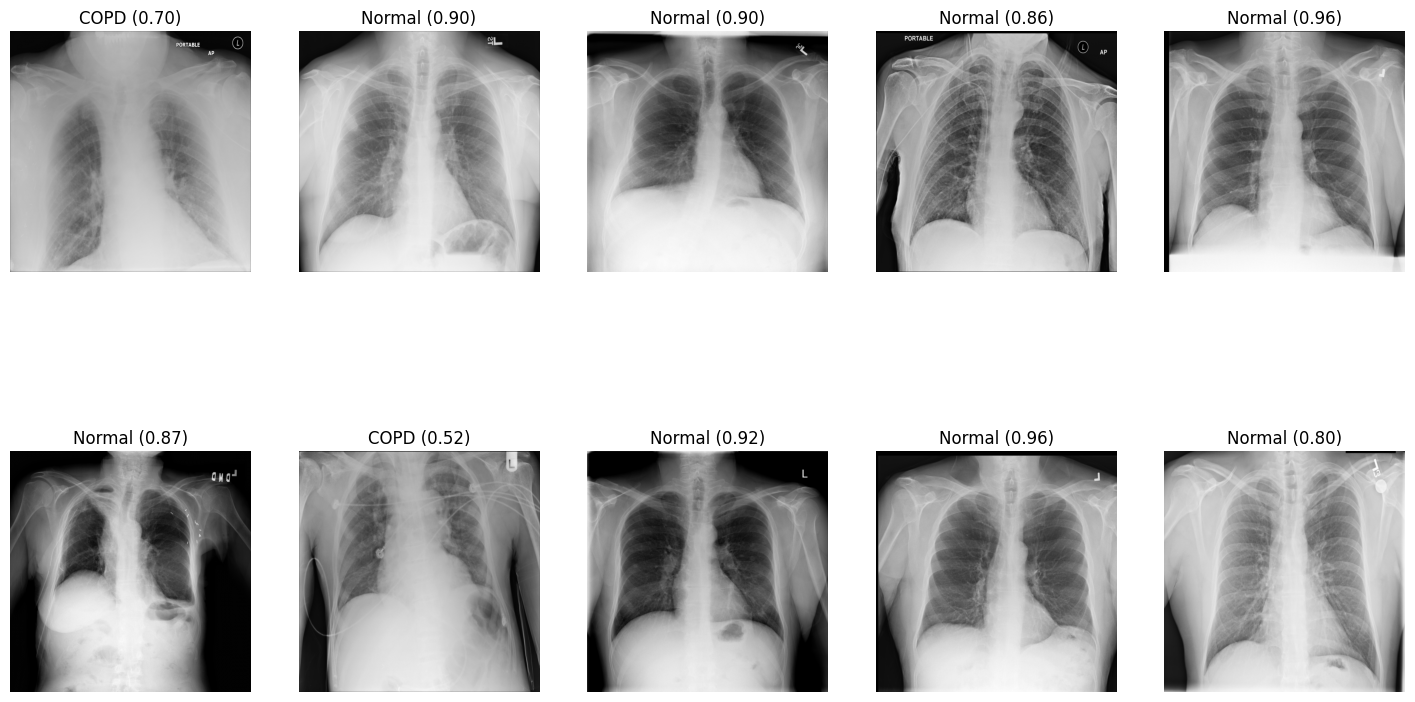

In [19]:
import random

def show_predictions_grid(folder, n=10):
    files = [os.path.join(folder, f) for f in os.listdir(folder)]
    files = [f for f in files if f.lower().endswith(("png","jpg","jpeg"))]

    num_samples = min(n, len(files))

    plt.figure(figsize=(18,10))

    for i, path in enumerate(random.sample(files, num_samples)):
        label, conf = predict_image(path)
        img = Image.open(path)

        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{label} ({conf:.2f})")
        plt.axis("off")

    plt.show()

show_predictions_grid("/content/COPD_Xray_Project_Dataset/test/Normal", n=10)

# using GAM HeatMap

In [20]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=0c36e9d67f606317825dc90826429adf965cb8b78aecb60baf496366d1f26bd7
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [22]:
target_layer = model.layer4[-1]


In [23]:
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    # Resize to the model's input size (192,192) for consistency
    img_resized = img.resize((192,192))

    img_np = np.array(img_resized) / 255.0
    # test_tf already contains a resize to (192,192), so img_resized should match this.
    img_tensor = test_tf(img_resized).unsqueeze(0).to(device)

    return img, img_np, img_tensor

In [24]:
def generate_gradcam(img_path):
    img, img_np, img_tensor = preprocess_image(img_path)

    # Removed 'use_cuda' as it's no longer a valid argument for GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    grayscale_cam = cam(input_tensor=img_tensor)[0]

    heatmap = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    return img, heatmap

In [25]:
def show_gradcam(img_path):
    img, heatmap = generate_gradcam(img_path)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Lung Heatmap")
    plt.axis("off")

    plt.show()


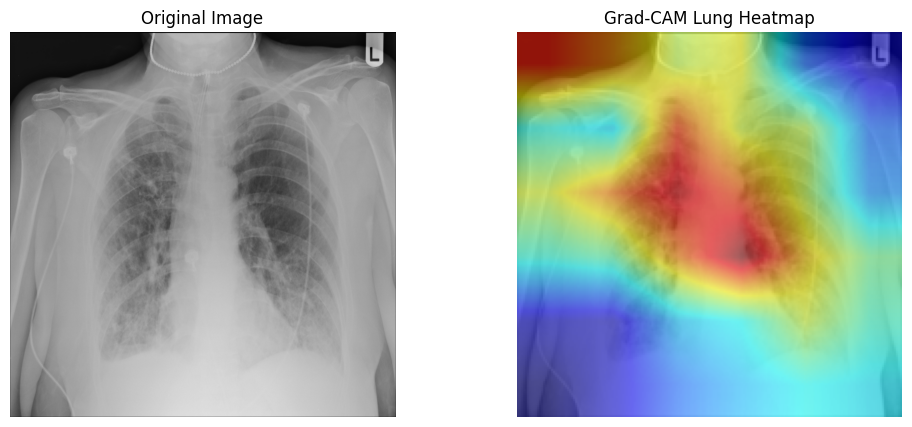

In [26]:
img_path = "/content/COPD_Xray_Project_Dataset/test/COPD/00001723_001.png"
show_gradcam(img_path)


# Prediction

In [27]:
pip install torch torchvision opencv-python numpy


In [28]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np

class BatchGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # Hook for forward pass
        target_layer.register_forward_hook(self.save_activation)

        # Hook for backward pass
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        """
        input_tensor: (B, C, H, W)
        class_idx: list or tensor of class indices for each image
        """

        output = self.model(input_tensor)    # (B, num_classes)

        # If class not provided, take predicted
        if class_idx is None:
            # Get the predicted class indices from the model's output
            predicted_class_indices = output.argmax(dim=1)
        else:
            predicted_class_indices = class_idx

        B = input_tensor.size(0)

        # Compute loss for each item in batch for backprop
        # This needs to be a scalar, so we sum the loss for the chosen classes
        loss = output[range(B), predicted_class_indices]
        loss = loss.sum()

        self.model.zero_grad()
        loss.backward()

        grads = self.gradients      # (B, C, H', W')
        acts = self.activations     # (B, C, H', W')

        B, C, H, W = acts.shape

        cams = []

        for i in range(B):
            weights = grads[i].mean(dim=(1, 2))     # (C)

            # Weighted combination
            cam = (weights.view(C, 1, 1) * acts[i]).sum(dim=0)

            cam = np.maximum(cam.cpu().numpy(), 0)  # ReLU
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)
            cams.append(cam)

        return cams, predicted_class_indices, output # Return cams, predicted indices, and raw output

In [29]:
def overlay_heatmap(image_tensor, cam):
    """
    image_tensor: (3, H, W) in [0,1]
    cam: (h, w) heatmap
    """

    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (0.4 * heatmap + 0.6 * img).astype(np.uint8)
    return overlay


In [30]:
def save_comparison(original, overlay, true_label, pred_label, index):
    h, w, _ = original.shape
    combined = np.hstack([original, overlay])

    # Add text labels
    cv2.putText(combined, f"True: {true_label}", (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    cv2.putText(combined, f"Pred: {pred_label}", (10, 45),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    cv2.imwrite(f"comparison_{index}.jpg", cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))


DEBUG - Model structure in 5biGvNDX-EgE:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


DEBUG - Image 0: Output shape: torch.Size([1, 2]), Output values: tensor([[ 0.0239, -0.0403]])
DEBUG - Image 1: Output shape: torch.Size([1, 2]), Output values: tensor([[ 0.5208, -0.6638]])
DEBUG - Image 2: Output shape: torch.Size([1, 2]), Output values: tensor([[-0.2109,  0.1491]])


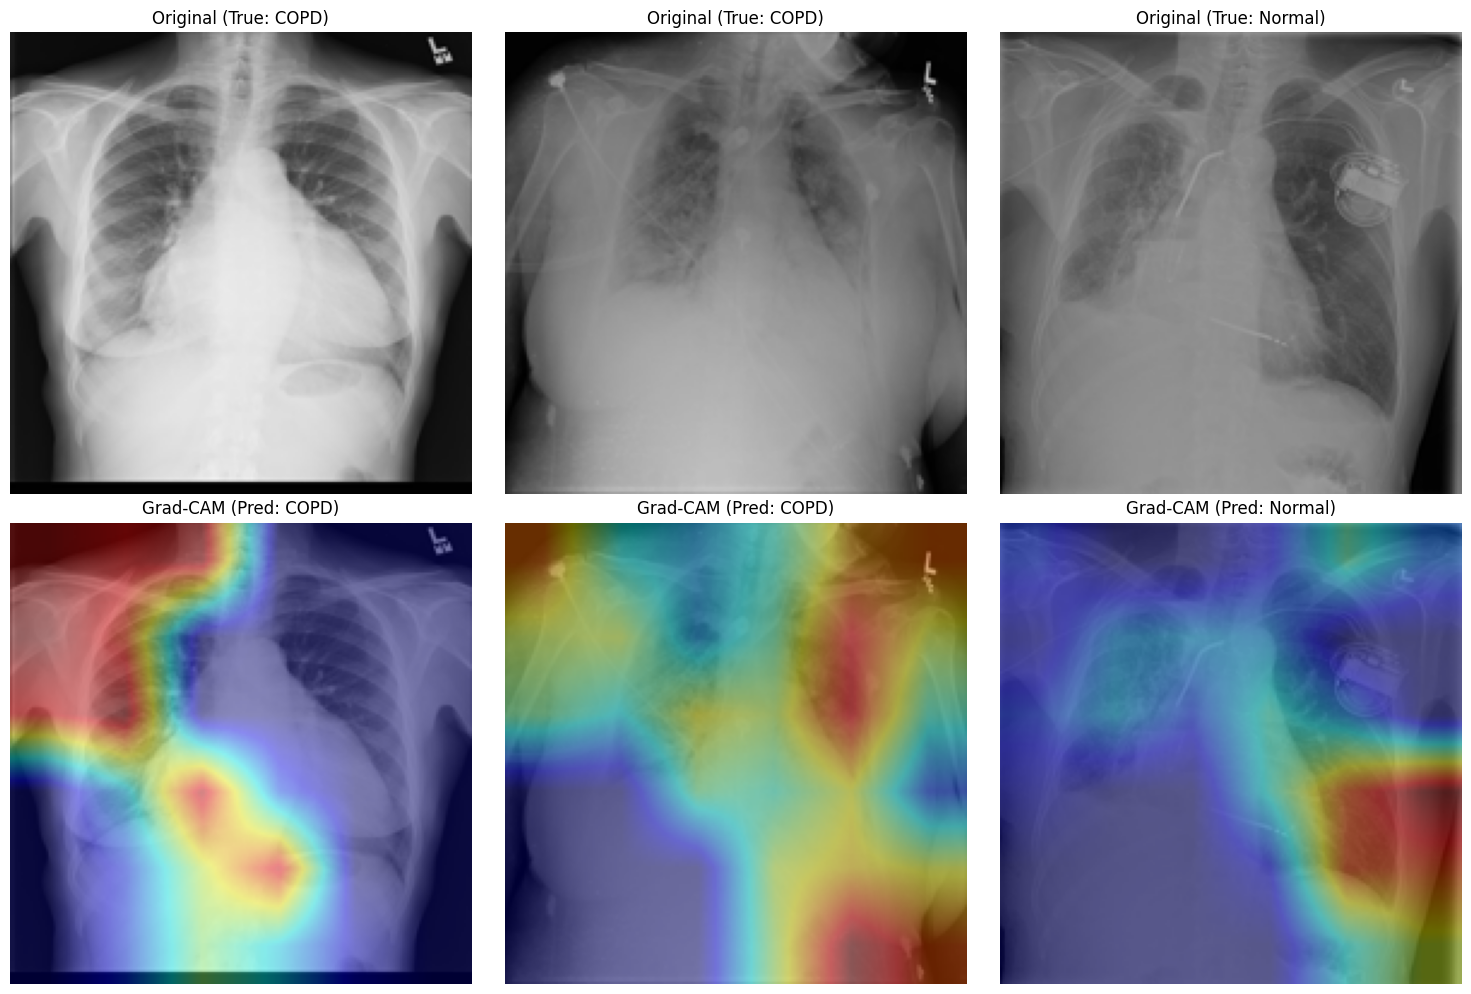

In [31]:
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2 # Ensure cv2 is imported for overlay_heatmap
import torch.nn as nn # Import nn for Sequential

# Explicitly set class_names to ensure consistency with the dataset
class_names = ['COPD', 'Normal']

# Re-initialize the model to ensure the correct one is used
model = models.resnet50(weights=None)
num_features = model.fc.in_features
# Redefine the classifier with the same structure as when it was saved
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
model.load_state_dict(torch.load("/content/copd_resnet50.pth", map_location=device))
model.to(device)
model.eval()

# The target_layer should be part of the re-initialized model
target_layer = model.layer4[-1]

# Initialize BatchGradCAM with the now-correctly loaded model and target_layer
cam = BatchGradCAM(model, target_layer)

# Transform: Should match the test_tf used for the fine-tuned model
transform = transforms.Compose([
    transforms.Resize((192,192)), # Model was trained with 192x192
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Matching test_tf normalization from TQEqO14iq8Rl
])

# Load batch of images (simulated)
image_paths = [
    "/content/COPD_Xray_Project_Dataset/test/COPD/00000211_006.png",
    "/content/COPD_Xray_Project_Dataset/test/COPD/00003028_008.png",
    "/content/COPD_Xray_Project_Dataset/test/Normal/00000013_015.png"
]
# Note: True labels are for display. Let's make them consistent with the global class_names.
# Assume 0 for COPD and 1 for Normal, based on the `label_map` in KB-pdMnaSY0G.
true_labels = [0, 0, 1]   # Example ground truth IDs for COPD, COPD, Normal

images_tensors = [transform(Image.open(p).convert("RGB")) for p in image_paths]
batch = torch.stack(images_tensors).to(device) # Move batch to device

# Ensure model is in evaluation mode
model.eval()

# Print model structure for debugging
print("DEBUG - Model structure in 5biGvNDX-EgE:\n", model)

# Generate Grad-CAM + predictions
# Updated to unpack cams, predicted_ids, and logits from the modified BatchGradCAM.generate
cams, predicted_ids, logits = cam.generate(batch)

# Loop through all images in batch
plt.figure(figsize=(len(image_paths) * 5, 10))
for i in range(len(images_tensors)):

    # Prepare original image for display and overlay
    original_img_pil = Image.open(image_paths[i]).convert("RGB").resize((192, 192))
    original_img_np = np.array(original_img_pil)
    original_img_tensor_for_overlay = transforms.ToTensor()(original_img_pil)

    # Use the overlay_heatmap function (defined in previous cells)
    overlay_img = overlay_heatmap(original_img_tensor_for_overlay, cams[i])

    # Plot original image
    plt.subplot(2, len(image_paths), i + 1)
    plt.imshow(original_img_np)
    plt.title(f"Original (True: {class_names[true_labels[i]]})")
    plt.axis("off")

    # Plot Grad-CAM overlay
    plt.subplot(2, len(image_paths), len(image_paths) + i + 1)
    plt.imshow(overlay_img)

    # Get prediction for the image to display in title for debugging
    with torch.no_grad():
        input_tensor_single = batch[i].unsqueeze(0)
        output = model(input_tensor_single)
        print(f"DEBUG - Image {i}: Output shape: {output.shape}, Output values: {output}")
        _, pred = torch.max(output, 1)

        # Robust indexing for class_names
        pred_idx = pred.item()
        if 0 <= pred_idx < len(class_names):
            predicted_class_name = class_names[pred_idx]
        else:
            print(f"Warning: Model predicted an out-of-range index: {pred_idx}. Defaulting to '{class_names[0]}'.")
            predicted_class_name = class_names[0] # Default to the first class

    plt.title(f"Grad-CAM (Pred: {predicted_class_name})")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [33]:
# ============================================
# ⭐ 1. IMPORT PACKAGES
# ============================================
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# ============================================
# ⭐ 2. DEVICE SETUP
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================
# ⭐ 3. REBUILD EXACT MODEL ARCHITECTURE
# ============================================
model = models.resnet50(weights=None)
num_features = model.fc.in_features

# This section must EXACTLY match how the model's fc layer was defined when SAVED.
# From previous successful training (cell TQEqO14iq8Rl) and model loading (cell ANuL771RpM5i),
# the structure was: Linear(num_ftrs, 256) -> ReLU -> Dropout(0.3) -> Linear(256, 2)
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)

# ============================================
# ⭐ 4. LOAD SAVED WEIGHTS
# ============================================
model.load_state_dict(torch.load("/content/copd_resnet50.pth", map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully!")

# ============================================
# ⭐ 5. IMAGE TRANSFORM
# ============================================
# This transform must also match what the model was trained/evaluated on
# which was (192, 192) resize and Normalize([0.5], [0.5]) as seen in TQEqO14iq8Rl
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ============================================
# ⭐ 6. PREDICTION FUNCTION
# ============================================
def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(x)
        probs = torch.softmax(output, dim=1)
        pred = probs.argmax().item()
        conf = probs[0][pred].item()

    # Class names should match the dataset labels: COPD (0), Normal (1)
    class_names = ['COPD', 'Normal'] # Ensure this matches global definition if used elsewhere
    label = class_names[pred] if 0 <= pred < len(class_names) else "Unknown"
    return label, conf, img

# ============================================
# ⭐ 7. GRAD-CAM IMPLEMENTATION
# ============================================
# Assuming BatchGradCAM class is defined in previous cells
# (from UsFB7Xvy8fQu)

# Find the target_layer (same as in pB6Pfnwt5OQv and 5biGvNDX-EgE)
target_layer = model.layer4[-1]

class BatchGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()

        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, tensor, class_idx=None):
        output = self.model(tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        loss = output[torch.arange(tensor.size(0)), class_idx].sum()

        self.model.zero_grad()
        loss.backward()

        cams = []
        acts = self.activations
        grads = self.gradients

        for i in range(tensor.size(0)):
            weights = grads[i].mean(dim=(1, 2))
            cam = (weights[:, None, None] * acts[i]).sum(dim=0)
            cam = np.maximum(cam.cpu().numpy(), 0)
            cam = cam / (cam.max() + 1e-8)
            cams.append(cam)

        return cams, class_idx.cpu().numpy()

# ============================================
# ⭐ 8. HEATMAP OVERLAY
# ============================================
def overlay_heatmap(img_tensor, cam):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(cam*255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    blended = (0.4 * heatmap + 0.6 * img).astype(np.uint8)
    return blended

# ============================================
# ⭐ 9. SHOW SINGLE PREDICTION + GRADCAM
# ============================================
def show_prediction_with_gradcam(path):
    label, conf, img = predict_image(path)

    tensor = transform(img).unsqueeze(0).to(device)

    # Initialize BatchGradCAM instance for this prediction
    cam_engine = BatchGradCAM(model, target_layer)
    cams, cls = cam_engine.generate(tensor)

    overlay = overlay_heatmap(tensor[0], cams[0])

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({conf:.2f})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.show()

# ============================================
# ⭐ 10. GRID OF RANDOM PREDICTIONS
# ============================================
def show_predictions_grid(folder, n=10):
    files = [os.path.join(folder, f) for f in os.listdir(folder)
             if f.lower().endswith(("png","jpg","jpeg"))]

    plt.figure(figsize=(20,10))
    for i, path in enumerate(random.sample(files, min(n, len(files)))):
        label, conf, img = predict_image(path)
        plt.subplot(2,5,i+1)
        plt.imshow(img)
        plt.title(f"{label} ({conf:.2f})")
        plt.axis("off")

    plt.show()

print("\nREADY! You can now use prediction and Grad-CAM functions.")

Using device: cpu
Model loaded successfully!

READY! You can now use prediction and Grad-CAM functions.


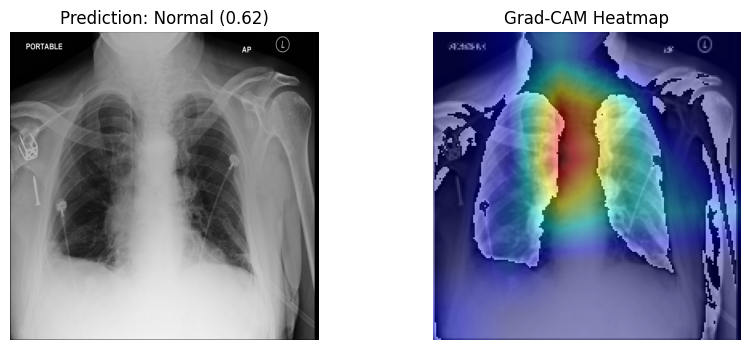

In [34]:
show_prediction_with_gradcam("/content/COPD_Xray_Project_Dataset/test/Normal/00000202_001.png")


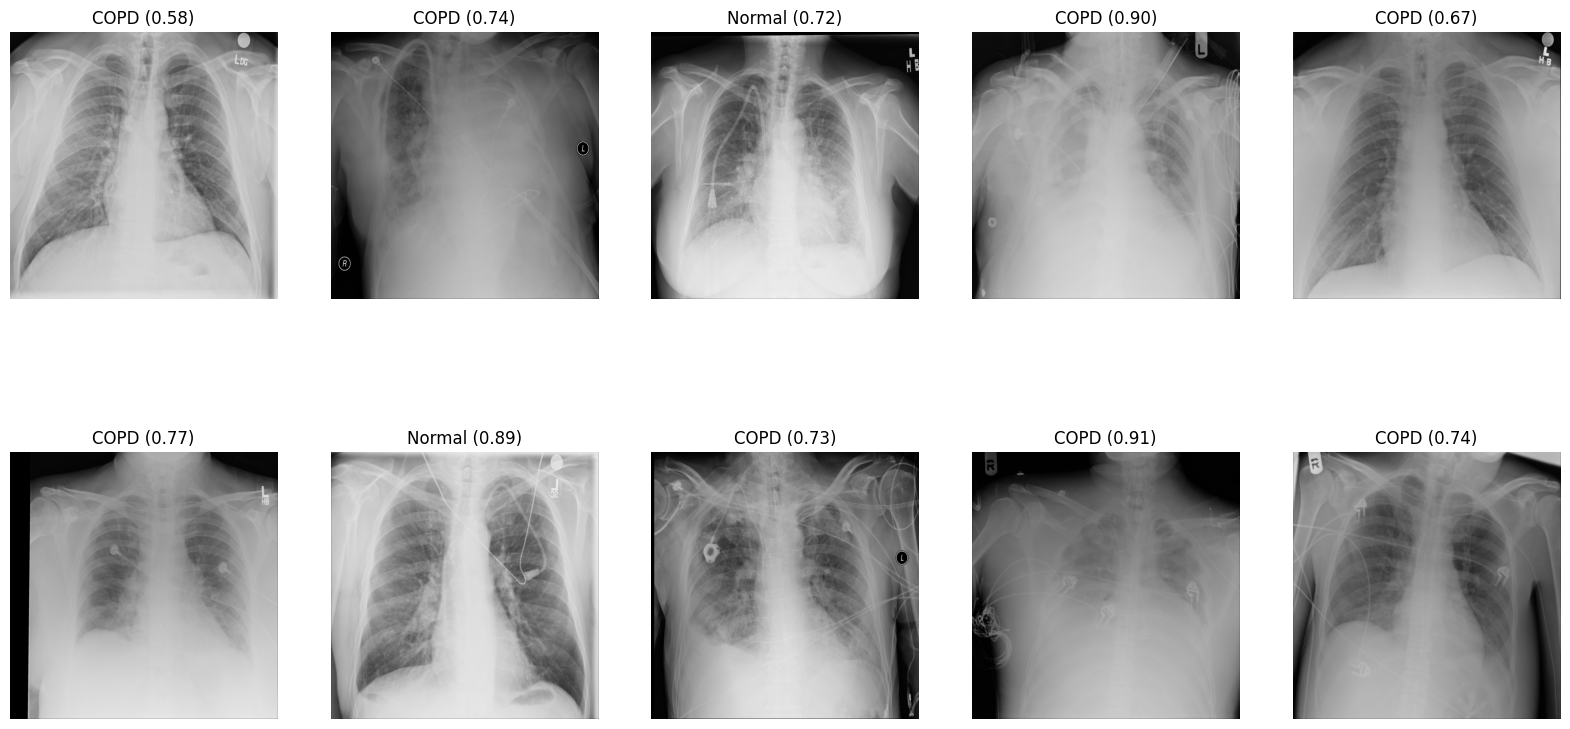

In [35]:
show_predictions_grid("/content/COPD_Xray_Project_Dataset/test/COPD", n=10)
